# Conditional DC-GAN for MRI Brain Image Synthesis

## Introduction

The recent increasing developments in generative adversarial networks(GAN) shows its huge potence in imgaes generations. Medical tumors datasets are often imbalanced and lack of diversity, whick is still chanllengable for trainging a deep learning model. In this project, I proposed a conditional generative neuralnet for creating synthetic medical brain images based on tumors and brain shapes.


## Methodes

## Experiment

#### MRI datasets 

The evaluation of this model is based on brain tumors imaging dataset(BraTS 2015). The original datast(7.5 Gb) are 3D resonnance iamges which contains 210 samples of brain in the training set. Each sample is a 3D matrix of size (155, 255, 255) which represent respectively the depth, height and width, i.e., 155 images of horizental brain slice. 

The preprocessing of dataset is composed of 2 steps:

1. Selected respectively 90 images from each 3D samples of type T2 and OT.

2. Create the input images by superpositioning the OT image on a background shape made from its related T2 image. We names these input as OT images with Background

3. split the dataset into training and testing set.

In particular, the dataset has been split into 2 folds, 70% for training and 30% for testing. 

For the propose of fast prototyping, this experiemnt focus on generating MRI of type T2 based on the tumors and background shapes. It is possible to repeat this experiements on the other type of iamges such as T1, T1C abd Flair.



#### Conditional GAN Model

This Conditional GAN Model is based on an autoencoder and a deep convelotional GAN(DCGAN). It takes the OT images latent representation as input and gives the Brain MRI image as output. All the iamges are resized in 64 x 64 for the efficiency of training. A typical training is composed of 4 parts:

1. In the first place, an autoencoder transforms the OT images with background(OTB) into a series of representations. it is pre-trained and do not update in the next steps.

2. Secondly, the DCGAN takes the representation of images as input and reproduces a MRI image based on the shape of brain and tumors. 

3. At last, the updating of neural net are composed of 3 parts: 
        1. calculate the losses in the DC GAN and update (both the Generator and Descriminator) 
        2. calculate the loss by between the generated fake images and their related T2 iamges(as ground truth) and update.

4. Repeat 2, 3 until the the loss converges or until the model generates resonable images. 

## Results and discussions

The model generats reasonable images respecting the form of brain and creates reliable textures for gray matter and white matter. Tumors marked in the OTB iamges are usually in the correct position and they are in majority well presented.  However, the resolution of generated images could be improved. It is expected to train a deep neural net model for higher-resolution generation on mutilple GPU in the next works. 

## Sample result


Sample 1
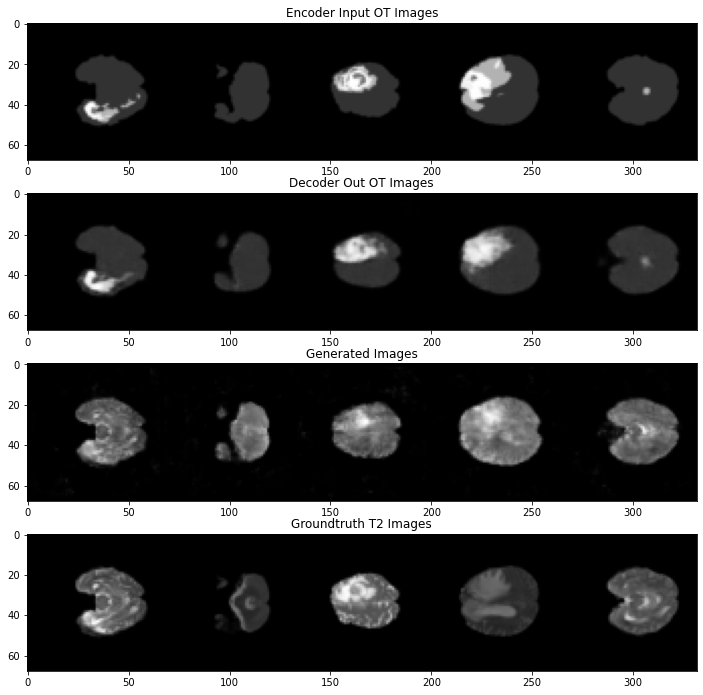

Sample 2
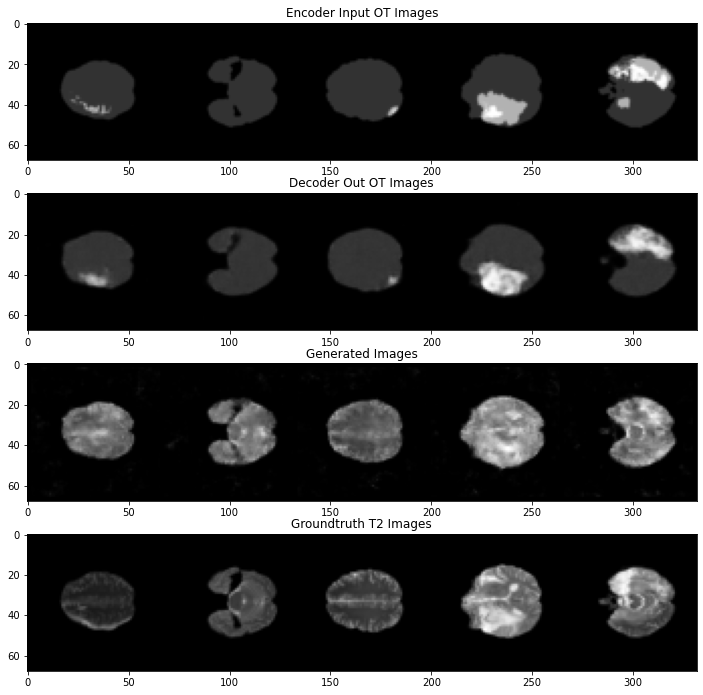

# Codes ann Experiments

In [364]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [365]:

torch.cuda.is_available()

True

In [366]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [404]:
# Root directory for dataset
dataroot_T2 = "./BraTS2015_Medium/T2/train"
dataroot_OT = "./BraTS2015_Medium/OT/train"
dataroot_OT_Back = "./BraTS2015_Medium/OT_BACKGROUND/train"

dataroot_T2_test = "./BraTS2015_Medium/T2/test"
dataroot_OT_test = "./BraTS2015_Medium/OT/test"
dataroot_OT_Back_test = "./BraTS2015_Medium/OT_BACKGROUND/test"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 25

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

#   size of fixed noise
fixed_noise_size = 25

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 400

# Size of Encoder latent vector (i.e. )
nz_encoder = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 800

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

Data

In [405]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset_T2 = dset.ImageFolder(root=dataroot_T2,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT = dset.ImageFolder(root=dataroot_OT,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))
dataset_OT_Back = dset.ImageFolder(root=dataroot_OT_Back,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_OT_Back_test = dset.ImageFolder(root=dataroot_OT_Back_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

dataset_T2_test = dset.ImageFolder(root=dataroot_T2_test,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Grayscale(),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5), (0.5)),
                           ]))

In [406]:
len(dataset_OT)

3168

In [407]:
class CustomerDataset(Dataset):

    def __init__(self, ds1, ds2):
        super(CustomerDataset, self).__init__()
        self.ds1 = [ds1[index][0] for index in range(len(ds1))]
        self.ds2 = [ds2[index][0] for index in range(len(ds2))]

    def __len__(self):
        return len(self.ds1)

    def __getitem__(self, index): 
        
        return self.ds1[index], self.ds2[index]


In [408]:
ds =  CustomerDataset(dataset_T2, dataset_OT_Back)

In [409]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size,pin_memory=True,timeout=0,
                                         shuffle=True, num_workers=workers)

In [410]:
for i, (ds1, ds2),  in enumerate(dataloader):  
    print(i, len(ds1), len(ds2))

0 25 25
1 25 25
2 25 25
3 25 25
4 25 25
5 25 25
6 25 25
7 25 25
8 25 25
9 25 25
10 25 25
11 25 25
12 25 25
13 25 25
14 25 25
15 25 25
16 25 25
17 25 25
18 25 25
19 25 25
20 25 25
21 25 25
22 25 25
23 25 25
24 25 25
25 25 25
26 25 25
27 25 25
28 25 25
29 25 25
30 25 25
31 25 25
32 25 25
33 25 25
34 25 25
35 25 25
36 25 25
37 25 25
38 25 25
39 25 25
40 25 25
41 25 25
42 25 25
43 25 25
44 25 25
45 25 25
46 25 25
47 25 25
48 25 25
49 25 25
50 25 25
51 25 25
52 25 25
53 25 25
54 25 25
55 25 25
56 25 25
57 25 25
58 25 25
59 25 25
60 25 25
61 25 25
62 25 25
63 25 25
64 25 25
65 25 25
66 25 25
67 25 25
68 25 25
69 25 25
70 25 25
71 25 25
72 25 25
73 25 25
74 25 25
75 25 25
76 25 25
77 25 25
78 25 25
79 25 25
80 25 25
81 25 25
82 25 25
83 25 25
84 25 25
85 25 25
86 25 25
87 25 25
88 25 25
89 25 25
90 25 25
91 25 25
92 25 25
93 25 25
94 25 25
95 25 25
96 25 25
97 25 25
98 25 25
99 25 25
100 25 25
101 25 25
102 25 25
103 25 25
104 25 25
105 25 25
106 25 25
107 25 25
108 25 25
109 25 25
110 25 25


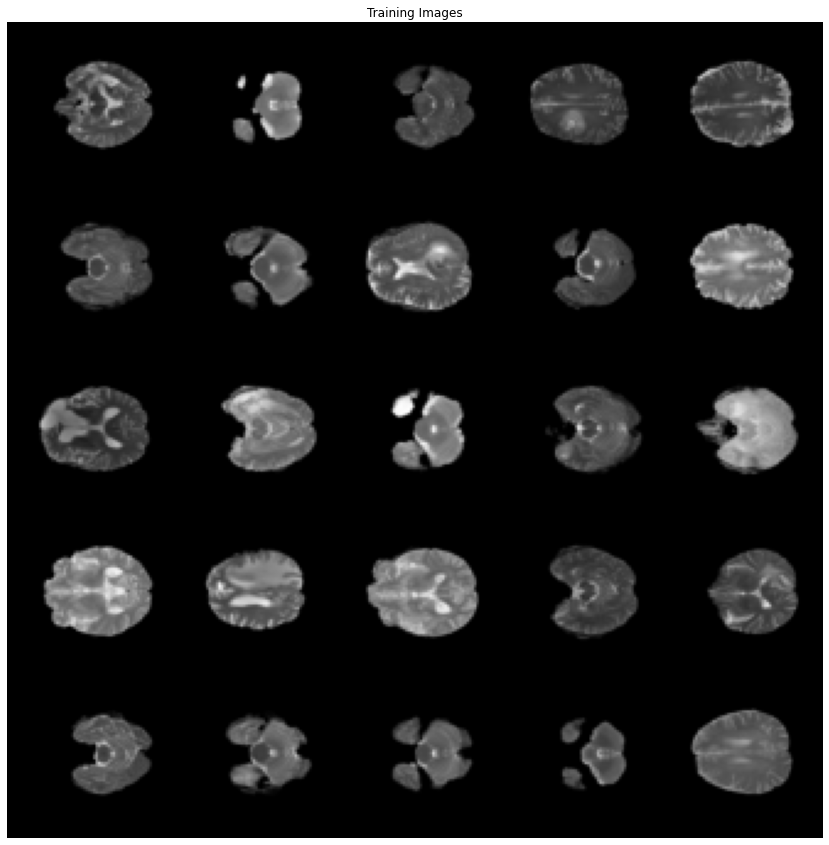

In [411]:

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:25], padding=2, normalize=True, nrow=5).cpu(),(1,2,0)))

Implementation

## Training autoencoder

In [412]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [413]:
class Encoder(nn.Module):
    def __init__(self, ngpu):
        super(Encoder, self).__init__()
        self.ngpu = ngpu  
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, nz_encoder, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
         
        

    def forward(self, input):
        return self.main(input)

In [414]:

class Decoder(nn.Module):
    def __init__(self, ngpu):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.activation = {}
        self.conv_relu_1 = nn.ReLU(True)
        self.conv_relu_2 = nn.ReLU(True)
        self.conv_relu_3 = nn.ReLU(True)
        self.conv_relu_4 = nn.ReLU(True)
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz_encoder, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            self.conv_relu_1,
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            self.conv_relu_2,
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            self.conv_relu_3,
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            self.conv_relu_4,
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        self.conv_relu_1.register_forward_hook(self.get_activation('conv_relu_1'))
        self.conv_relu_2.register_forward_hook(self.get_activation('conv_relu_2'))
        self.conv_relu_3.register_forward_hook(self.get_activation('conv_relu_3'))
        self.conv_relu_4.register_forward_hook(self.get_activation('conv_relu_4'))
            
    def forward(self, input):
        return self.main(input)
    
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook

In [415]:
# Create the Discriminator
netEncoder = Encoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netEncoder = nn.DataParallel(netEncoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netEncoder.apply(weights_init)

# Print the model
print(netEncoder)

Encoder(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [416]:
# Create the Discriminator
netDecoder = Decoder(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netDecoder = nn.DataParallel(netDecoder, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netDecoder.apply(weights_init)

# Print the model
print(netDecoder)

Decoder(
  (conv_relu_1): ReLU(inplace=True)
  (conv_relu_2): ReLU(inplace=True)
  (conv_relu_3): ReLU(inplace=True)
  (conv_relu_4): ReLU(inplace=True)
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1

In [417]:
# Initialize MSELoss function
mesloss = torch.nn.MSELoss()


#  the progression of the generator
selected_index = np.random.randint(len(ds), size=fixed_noise_size)
fixed_ot_image = torch.stack([ds[i][1] for i in selected_index]).to(device)

# Setup Adam optimizers for both G and D
optimizerDecoder = optim.Adam(netDecoder.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerEncoder = optim.Adam(netEncoder.parameters(), lr=lr, betas=(beta1, 0.999))

In [418]:
# Training Loop

# Lists to keep track of progress
img_list = [] 
losses = []

iters = 0
netDecoder
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_t2, data_ot) in enumerate(dataloader, 0):

        
        
        ############################
        # (1) Update Encoder network:  
        ############################
        ## Train with all-real batch
        
        real_cpu = data_ot.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = real_cpu.size(0)
        
        netEncoder.zero_grad()
        netDecoder.zero_grad()
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        #print(real_cpu.shape)
        representation = netEncoder(real_cpu).view(b_size,-1,1,1)
        #print(representation.shape)
        
        output = netDecoder(representation).view(real_cpu.shape)
        
        # Calculate loss on all-real batch 
        err = mesloss(output, real_cpu)
        
        # Calculate gradients for G
        err.backward()
        D_x = err.mean().item()
        
        # Update 
        optimizerDecoder.step()
        optimizerEncoder.step()
        
         

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     err.item()))

        # Save Losses for plotting later
        losses.append(err.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
            #print(images_to_plot.shape)
            img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/800][0/127]	Loss: 0.6866
[0/800][50/127]	Loss: 0.0628
[0/800][100/127]	Loss: 0.0293
[1/800][0/127]	Loss: 0.0224
[1/800][50/127]	Loss: 0.0170
[1/800][100/127]	Loss: 0.0140
[2/800][0/127]	Loss: 0.0118
[2/800][50/127]	Loss: 0.0097
[2/800][100/127]	Loss: 0.0088
[3/800][0/127]	Loss: 0.0082
[3/800][50/127]	Loss: 0.0085
[3/800][100/127]	Loss: 0.0069
[4/800][0/127]	Loss: 0.0067
[4/800][50/127]	Loss: 0.0060
[4/800][100/127]	Loss: 0.0053
[5/800][0/127]	Loss: 0.0071
[5/800][50/127]	Loss: 0.0056
[5/800][100/127]	Loss: 0.0054
[6/800][0/127]	Loss: 0.0051
[6/800][50/127]	Loss: 0.0051
[6/800][100/127]	Loss: 0.0044
[7/800][0/127]	Loss: 0.0053
[7/800][50/127]	Loss: 0.0046
[7/800][100/127]	Loss: 0.0042
[8/800][0/127]	Loss: 0.0043
[8/800][50/127]	Loss: 0.0041
[8/800][100/127]	Loss: 0.0040
[9/800][0/127]	Loss: 0.0039
[9/800][50/127]	Loss: 0.0042
[9/800][100/127]	Loss: 0.0032
[10/800][0/127]	Loss: 0.0033
[10/800][50/127]	Loss: 0.0025
[10/800][100/127]	Loss: 0.0032
[11/800][0/127

KeyboardInterrupt: 

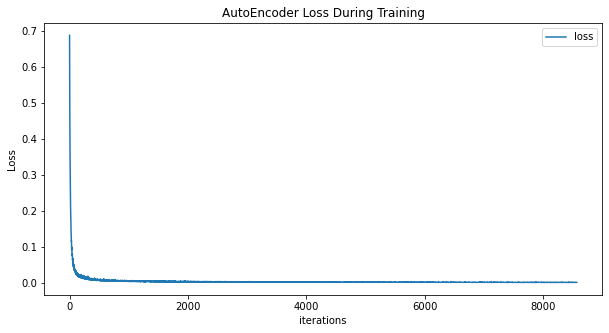

In [419]:
plt.figure(figsize=(10,5))
plt.title("AutoEncoder Loss During Training")
plt.plot(losses,label="loss")
#plt.plot(D_losses,label="Encoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [420]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)

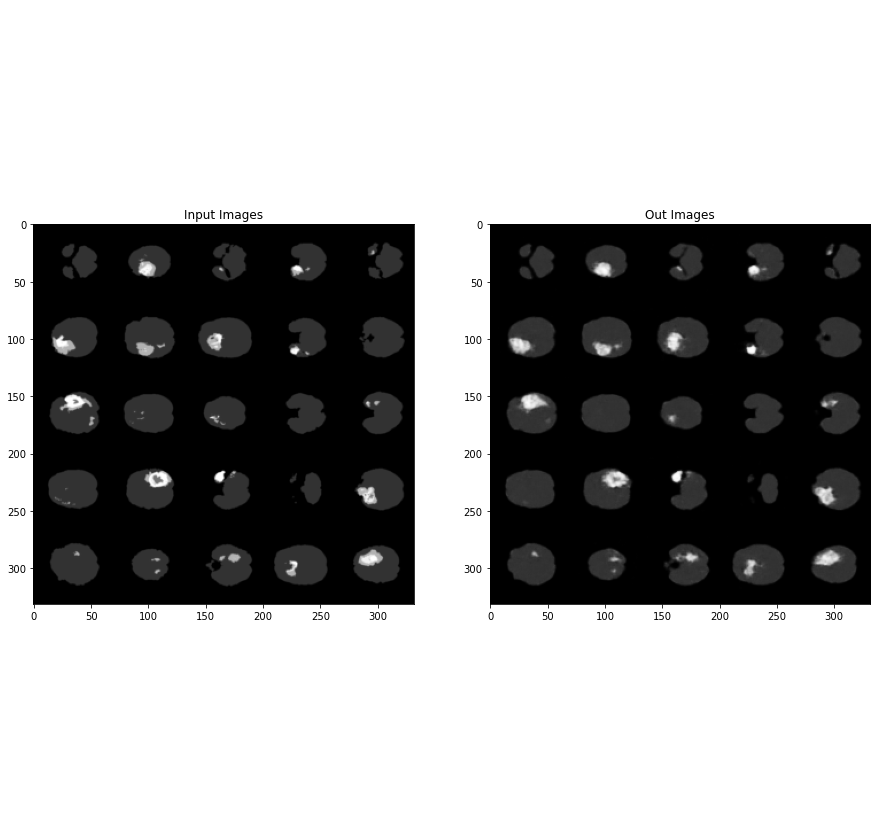

In [421]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)

    images_to_plot = torch.cat((real_cpu, output), dim=0).cpu()
    vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5)
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(1, 2, 1)
plt.title("Input Images")
img = np.transpose(vutils.make_grid(real_cpu, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)


fig.add_subplot(1, 2, 2)
plt.title("Out Images")
img = np.transpose(vutils.make_grid(output, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

In [422]:
netDecoder.activation["conv_relu_1"].shape

torch.Size([25, 512, 4, 4])

In [423]:
netDecoder.activation["conv_relu_2"].shape

torch.Size([25, 256, 8, 8])

In [424]:
netDecoder.activation["conv_relu_3"].shape

torch.Size([25, 128, 16, 16])

In [425]:
netDecoder.activation["conv_relu_4"].shape

torch.Size([25, 64, 32, 32])

### Conditional GAN with Autoencoder mask layer as input

Generator

In [447]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.seq_1 = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz + nz_encoder, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
        )
        self.seq_2 = nn.Sequential( 
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8 * 2, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
         )
        self.seq_3 = nn.Sequential( 
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4 * 2, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
         )
        self.seq_4 = nn.Sequential( 
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2 * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
         )
        self.seq_5 = nn.Sequential( 
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input, conv_1, conv_2, conv_3, conv_4):
        res = self.seq_1(input)
        res = self.seq_2(torch.cat((res, conv_1), dim=1))
        res = self.seq_3(torch.cat((res, conv_2), dim=1))
        res = self.seq_4(torch.cat((res, conv_3), dim=1))
        res = self.seq_5(torch.cat((res, conv_4), dim=1))
        
        return res

In [448]:
# Create the generator

netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (seq_1): Sequential(
    (0): ConvTranspose2d(500, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (seq_2): Sequential(
    (0): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (seq_3): Sequential(
    (0): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (seq_4): Sequential(
    (0): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (seq_5): Sequential(
    (0): Co

Discriminator

In [449]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ) 
    def forward(self, input):
        return self.main(input)
    

In [450]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers


In [451]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Initialize MSELoss function
mesloss = torch.nn.MSELoss()
        

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

Training

In [ ]:

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
GenEncoder_losses = []
iters = 0


In [458]:
# Training Loop

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (data_t2, data_ot) in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_cpu = data_t2.to(device)
        #print("real_cpu.shape", real_cpu.shape)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        # Calculate loss on all-real batch 
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        
        ##Forward pass on OT tumors images
        #load tumors images
        real_cpu_ot = data_ot.to(device)
        with torch.no_grad():
            #calculate representations
            representaion = netEncoder(real_cpu_ot).view(b_size,-1, 1, 1)
            decode_output = netDecoder(representaion).view(b_size,-1, 1, 1)
            conv_1 = netDecoder.activation['conv_relu_1']
            conv_2 = netDecoder.activation['conv_relu_2']
            conv_3 = netDecoder.activation['conv_relu_3']
            conv_4 = netDecoder.activation['conv_relu_4']
            
        #print(representaion.shape)
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        stacked_input = torch.cat((noise, representaion), dim=1 )
        
        #print(stacked_input.shape)
        
        fake = netG(stacked_input, conv_1, conv_2, conv_3, conv_4)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        
        # Update G
        #optimizerG.step()
        
        # Calculate loss on all-real batch 
        errEncoder = mesloss(fake, real_cpu) *5
        
        # Calculate gradients for G
        errEncoder.backward()
        G_mse = errEncoder.mean().item()
        
        # Update G for Encoder mse error
        optimizerG.step()
        
        

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tG_mse: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, G_mse))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        GenEncoder_losses.append(errEncoder.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
                fake = netG(fixed_stacked_input, conv_1, conv_2, conv_3, conv_4).detach()
            images_to_plot = torch.cat((real_cpu_ot, real_cpu, fake), dim=0).cpu()
            #print(images_to_plot.shape)
            img_list.append(vutils.make_grid(images_to_plot, padding=2, normalize=True, nrow=5))

        iters += 1

Starting Training Loop...
[0/800][0/127]	Loss_D: 0.2340	Loss_G: 3.0199	D(x): 0.8788	D(G(z)): 0.0644 / 0.0610	G_mse: 0.0588
[0/800][50/127]	Loss_D: 0.3239	Loss_G: 5.1339	D(x): 0.9622	D(G(z)): 0.2077 / 0.0104	G_mse: 0.0564
[0/800][100/127]	Loss_D: 0.4522	Loss_G: 2.5506	D(x): 0.7528	D(G(z)): 0.0908 / 0.1121	G_mse: 0.0590
[1/800][0/127]	Loss_D: 0.2689	Loss_G: 4.6431	D(x): 0.9254	D(G(z)): 0.1531 / 0.0157	G_mse: 0.0506
[1/800][50/127]	Loss_D: 0.4326	Loss_G: 4.2739	D(x): 0.9638	D(G(z)): 0.2745 / 0.0228	G_mse: 0.0797
[1/800][100/127]	Loss_D: 0.2409	Loss_G: 3.1822	D(x): 0.8278	D(G(z)): 0.0411 / 0.0609	G_mse: 0.0675
[2/800][0/127]	Loss_D: 0.2636	Loss_G: 4.0818	D(x): 0.9805	D(G(z)): 0.1862 / 0.0239	G_mse: 0.0689
[2/800][50/127]	Loss_D: 0.3283	Loss_G: 2.4845	D(x): 0.8017	D(G(z)): 0.0412 / 0.1069	G_mse: 0.0612
[2/800][100/127]	Loss_D: 0.6843	Loss_G: 2.1502	D(x): 0.6929	D(G(z)): 0.0288 / 0.2002	G_mse: 0.0671
[3/800][0/127]	Loss_D: 0.6634	Loss_G: 2.9417	D(x): 0.6368	D(G(z)): 0.0137 / 0.0773	G_mse: 0.

[27/800][100/127]	Loss_D: 0.1469	Loss_G: 4.7979	D(x): 0.9904	D(G(z)): 0.1075 / 0.0109	G_mse: 0.0718
[28/800][0/127]	Loss_D: 0.3554	Loss_G: 4.7270	D(x): 0.8825	D(G(z)): 0.1141 / 0.0202	G_mse: 0.0683
[28/800][50/127]	Loss_D: 0.1219	Loss_G: 4.3792	D(x): 0.9418	D(G(z)): 0.0493 / 0.0157	G_mse: 0.0649
[28/800][100/127]	Loss_D: 0.0986	Loss_G: 4.9583	D(x): 0.9676	D(G(z)): 0.0606 / 0.0100	G_mse: 0.0555
[29/800][0/127]	Loss_D: 3.1110	Loss_G: 11.6642	D(x): 0.9959	D(G(z)): 0.8983 / 0.0000	G_mse: 0.0505
[29/800][50/127]	Loss_D: 0.3034	Loss_G: 3.9080	D(x): 0.8833	D(G(z)): 0.0892 / 0.0274	G_mse: 0.0622
[29/800][100/127]	Loss_D: 0.3418	Loss_G: 4.3949	D(x): 0.8177	D(G(z)): 0.0898 / 0.0208	G_mse: 0.0600
[30/800][0/127]	Loss_D: 0.4575	Loss_G: 6.2131	D(x): 0.9867	D(G(z)): 0.2314 / 0.0046	G_mse: 0.0581
[30/800][50/127]	Loss_D: 0.2174	Loss_G: 3.7328	D(x): 0.8616	D(G(z)): 0.0196 / 0.0361	G_mse: 0.0516
[30/800][100/127]	Loss_D: 0.2241	Loss_G: 3.4131	D(x): 0.8696	D(G(z)): 0.0628 / 0.0430	G_mse: 0.0725
[31/800]

[55/800][50/127]	Loss_D: 0.3595	Loss_G: 2.8868	D(x): 0.7458	D(G(z)): 0.0173 / 0.1309	G_mse: 0.0710
[55/800][100/127]	Loss_D: 0.0926	Loss_G: 4.7269	D(x): 0.9855	D(G(z)): 0.0700 / 0.0114	G_mse: 0.0852
[56/800][0/127]	Loss_D: 0.0803	Loss_G: 4.8035	D(x): 0.9851	D(G(z)): 0.0600 / 0.0129	G_mse: 0.0585
[56/800][50/127]	Loss_D: 0.0705	Loss_G: 4.8939	D(x): 0.9523	D(G(z)): 0.0163 / 0.0107	G_mse: 0.0623
[56/800][100/127]	Loss_D: 0.0724	Loss_G: 4.7284	D(x): 0.9721	D(G(z)): 0.0407 / 0.0140	G_mse: 0.0741
[57/800][0/127]	Loss_D: 0.3990	Loss_G: 7.3067	D(x): 0.9758	D(G(z)): 0.2289 / 0.0017	G_mse: 0.0700
[57/800][50/127]	Loss_D: 0.2054	Loss_G: 5.5355	D(x): 0.9814	D(G(z)): 0.1281 / 0.0070	G_mse: 0.0418
[57/800][100/127]	Loss_D: 0.3485	Loss_G: 6.4323	D(x): 0.9944	D(G(z)): 0.2336 / 0.0081	G_mse: 0.0753
[58/800][0/127]	Loss_D: 0.1400	Loss_G: 6.0531	D(x): 0.9809	D(G(z)): 0.1026 / 0.0038	G_mse: 0.0518
[58/800][50/127]	Loss_D: 0.2073	Loss_G: 3.9143	D(x): 0.9500	D(G(z)): 0.1222 / 0.0352	G_mse: 0.0511
[58/800][1

[83/800][0/127]	Loss_D: 0.1032	Loss_G: 5.4921	D(x): 0.9914	D(G(z)): 0.0807 / 0.0064	G_mse: 0.0495
[83/800][50/127]	Loss_D: 0.0832	Loss_G: 3.9441	D(x): 0.9471	D(G(z)): 0.0254 / 0.0341	G_mse: 0.0550
[83/800][100/127]	Loss_D: 0.1463	Loss_G: 5.5211	D(x): 0.9920	D(G(z)): 0.0810 / 0.0075	G_mse: 0.0615
[84/800][0/127]	Loss_D: 0.0332	Loss_G: 5.6701	D(x): 0.9926	D(G(z)): 0.0246 / 0.0065	G_mse: 0.0691
[84/800][50/127]	Loss_D: 0.0852	Loss_G: 4.4460	D(x): 0.9505	D(G(z)): 0.0295 / 0.0182	G_mse: 0.0651
[84/800][100/127]	Loss_D: 0.0482	Loss_G: 4.9381	D(x): 0.9886	D(G(z)): 0.0333 / 0.0109	G_mse: 0.0595
[85/800][0/127]	Loss_D: 0.0519	Loss_G: 5.6322	D(x): 0.9945	D(G(z)): 0.0436 / 0.0052	G_mse: 0.0556
[85/800][50/127]	Loss_D: 0.7448	Loss_G: 1.8335	D(x): 0.6437	D(G(z)): 0.0098 / 0.2545	G_mse: 0.0523
[85/800][100/127]	Loss_D: 0.3019	Loss_G: 3.1351	D(x): 0.7890	D(G(z)): 0.0263 / 0.0931	G_mse: 0.0786
[86/800][0/127]	Loss_D: 0.3484	Loss_G: 4.2494	D(x): 0.8822	D(G(z)): 0.0570 / 0.0353	G_mse: 0.0573
[86/800][50

[110/800][100/127]	Loss_D: 0.0841	Loss_G: 5.1482	D(x): 0.9347	D(G(z)): 0.0104 / 0.0142	G_mse: 0.0862
[111/800][0/127]	Loss_D: 0.0354	Loss_G: 5.1776	D(x): 0.9982	D(G(z)): 0.0325 / 0.0083	G_mse: 0.0543
[111/800][50/127]	Loss_D: 0.0288	Loss_G: 5.1682	D(x): 0.9879	D(G(z)): 0.0161 / 0.0114	G_mse: 0.0626
[111/800][100/127]	Loss_D: 0.1293	Loss_G: 5.5461	D(x): 0.9715	D(G(z)): 0.0894 / 0.0078	G_mse: 0.0480
[112/800][0/127]	Loss_D: 0.1846	Loss_G: 4.1726	D(x): 0.9132	D(G(z)): 0.0124 / 0.0247	G_mse: 0.0792
[112/800][50/127]	Loss_D: 0.1096	Loss_G: 5.2216	D(x): 0.9698	D(G(z)): 0.0638 / 0.0087	G_mse: 0.0465
[112/800][100/127]	Loss_D: 0.1415	Loss_G: 3.6518	D(x): 0.9428	D(G(z)): 0.0516 / 0.0509	G_mse: 0.0360
[113/800][0/127]	Loss_D: 0.9028	Loss_G: 2.3325	D(x): 0.5808	D(G(z)): 0.0241 / 0.2030	G_mse: 0.0956
[113/800][50/127]	Loss_D: 0.3753	Loss_G: 3.6314	D(x): 0.7726	D(G(z)): 0.0392 / 0.0490	G_mse: 0.0542
[113/800][100/127]	Loss_D: 0.1200	Loss_G: 4.6869	D(x): 0.9659	D(G(z)): 0.0711 / 0.0157	G_mse: 0.0464

[138/800][0/127]	Loss_D: 0.1065	Loss_G: 4.6912	D(x): 0.9716	D(G(z)): 0.0564 / 0.0126	G_mse: 0.0408
[138/800][50/127]	Loss_D: 1.0021	Loss_G: 4.7502	D(x): 0.8793	D(G(z)): 0.4040 / 0.0117	G_mse: 0.0660
[138/800][100/127]	Loss_D: 0.1907	Loss_G: 5.8756	D(x): 0.9575	D(G(z)): 0.1030 / 0.0076	G_mse: 0.0616
[139/800][0/127]	Loss_D: 0.0945	Loss_G: 5.0762	D(x): 0.9973	D(G(z)): 0.0828 / 0.0079	G_mse: 0.0623
[139/800][50/127]	Loss_D: 0.0637	Loss_G: 4.4161	D(x): 0.9589	D(G(z)): 0.0197 / 0.0189	G_mse: 0.0460
[139/800][100/127]	Loss_D: 0.0648	Loss_G: 5.1738	D(x): 0.9710	D(G(z)): 0.0335 / 0.0134	G_mse: 0.0602
[140/800][0/127]	Loss_D: 0.2710	Loss_G: 3.5496	D(x): 0.8402	D(G(z)): 0.0461 / 0.0579	G_mse: 0.0512
[140/800][50/127]	Loss_D: 0.1094	Loss_G: 4.0387	D(x): 0.9213	D(G(z)): 0.0226 / 0.0306	G_mse: 0.0451
[140/800][100/127]	Loss_D: 0.0432	Loss_G: 5.1857	D(x): 0.9686	D(G(z)): 0.0100 / 0.0120	G_mse: 0.0575
[141/800][0/127]	Loss_D: 0.3248	Loss_G: 5.4260	D(x): 0.9460	D(G(z)): 0.1446 / 0.0114	G_mse: 0.0379
[

[165/800][50/127]	Loss_D: 0.0133	Loss_G: 5.6900	D(x): 0.9929	D(G(z)): 0.0061 / 0.0051	G_mse: 0.0699
[165/800][100/127]	Loss_D: 0.0451	Loss_G: 5.5010	D(x): 0.9975	D(G(z)): 0.0399 / 0.0053	G_mse: 0.0577
[166/800][0/127]	Loss_D: 0.0347	Loss_G: 5.2865	D(x): 0.9727	D(G(z)): 0.0067 / 0.0072	G_mse: 0.0396
[166/800][50/127]	Loss_D: 0.2032	Loss_G: 3.6592	D(x): 0.8782	D(G(z)): 0.0273 / 0.0516	G_mse: 0.0414
[166/800][100/127]	Loss_D: 0.0665	Loss_G: 4.4875	D(x): 0.9635	D(G(z)): 0.0240 / 0.0167	G_mse: 0.0648
[167/800][0/127]	Loss_D: 0.6839	Loss_G: 11.4694	D(x): 0.9933	D(G(z)): 0.3496 / 0.0000	G_mse: 0.0641
[167/800][50/127]	Loss_D: 0.2815	Loss_G: 4.4876	D(x): 0.9433	D(G(z)): 0.1680 / 0.0232	G_mse: 0.0581
[167/800][100/127]	Loss_D: 0.5982	Loss_G: 6.8801	D(x): 0.9889	D(G(z)): 0.3310 / 0.0020	G_mse: 0.0608
[168/800][0/127]	Loss_D: 0.4513	Loss_G: 7.4073	D(x): 0.9947	D(G(z)): 0.2770 / 0.0011	G_mse: 0.0659
[168/800][50/127]	Loss_D: 0.0704	Loss_G: 5.1056	D(x): 0.9741	D(G(z)): 0.0392 / 0.0112	G_mse: 0.0832

KeyboardInterrupt: 

## Results 

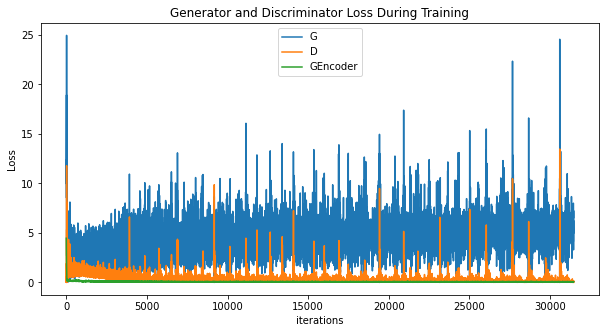

In [459]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(GenEncoder_losses,label="GEncoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [466]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)
fixed_T2_image = torch.stack([dataset_T2_test[i][0] for i in selected_index]).to(device)

In [467]:
selected_index

array([ 21, 486, 575, 500, 580,  43, 220, 704,  76, 540, 712, 141, 631,
        36, 226, 257,   2, 474, 381, 461, 263, 120, 628, 425, 435])

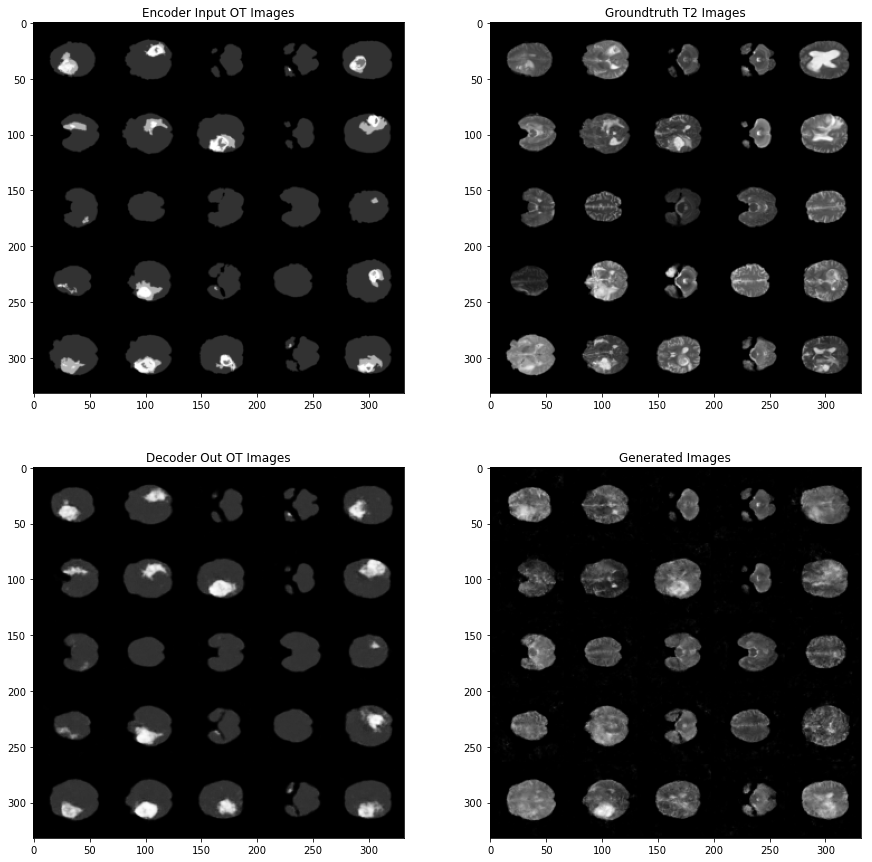

In [463]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)
    conv_1 = netDecoder.activation['conv_relu_1']
    conv_2 = netDecoder.activation['conv_relu_2']
    conv_3 = netDecoder.activation['conv_relu_3']
    conv_4 = netDecoder.activation['conv_relu_4']
 
    fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
    fake = netG(fixed_stacked_input,conv_1,conv_2,conv_3,conv_4).detach()
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(2, 2, 1)
plt.title("Encoder Input OT Images")
img = np.transpose(vutils.make_grid(fixed_OT_image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 2)
plt.title("Groundtruth T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(2, 2, 3)
plt.title("Decoder Out OT Images")
img = np.transpose(vutils.make_grid(output, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 4)
plt.title("Generated Images")
img = np.transpose(vutils.make_grid(fake, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

In [466]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)
fixed_T2_image = torch.stack([dataset_T2_test[i][0] for i in selected_index]).to(device)

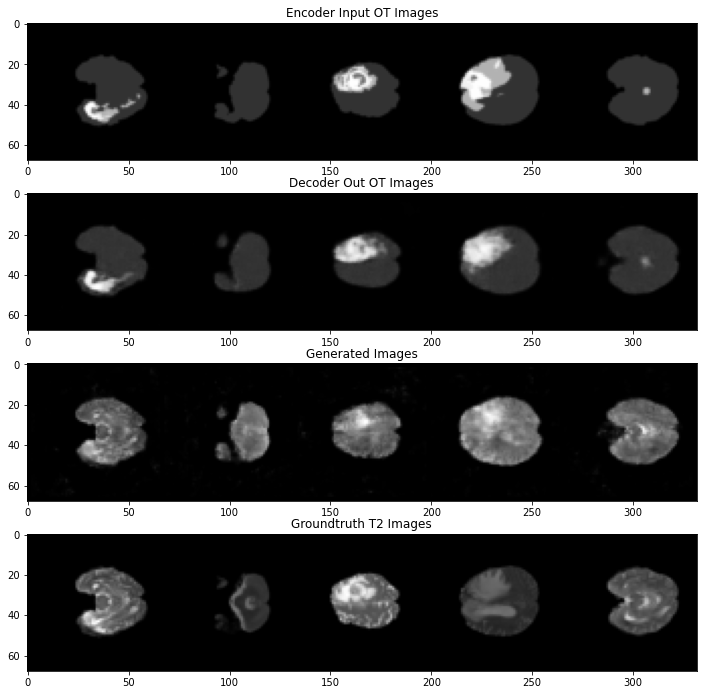

In [470]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)
    conv_1 = netDecoder.activation['conv_relu_1']
    conv_2 = netDecoder.activation['conv_relu_2']
    conv_3 = netDecoder.activation['conv_relu_3']
    conv_4 = netDecoder.activation['conv_relu_4']
 
    fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
    fake = netG(fixed_stacked_input,conv_1,conv_2,conv_3,conv_4).detach()
    

# Plot some training images 
fig=plt.figure(figsize=(12,12))
plt.axis("off")


fig.add_subplot(4, 1, 1)
plt.title("Encoder Input OT Images")
img = np.transpose(vutils.make_grid(fixed_OT_image[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 

fig.add_subplot(4, 1, 2)
plt.title("Decoder Out OT Images")
img = np.transpose(vutils.make_grid(output[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(4, 1, 3)
plt.title("Generated Images")
img = np.transpose(vutils.make_grid(fake[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(4, 1, 4)
plt.title("Groundtruth T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

In [484]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)
fixed_T2_image = torch.stack([dataset_T2_test[i][0] for i in selected_index]).to(device)

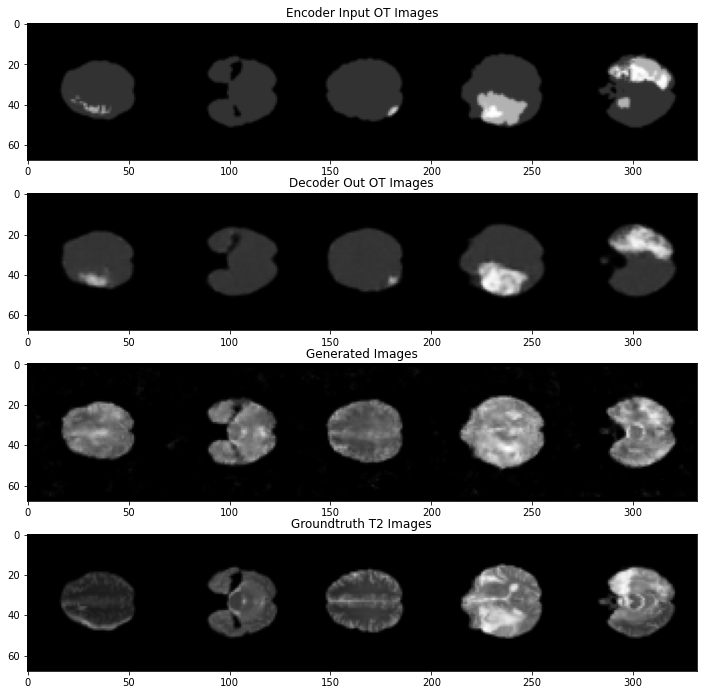

In [485]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)
    conv_1 = netDecoder.activation['conv_relu_1']
    conv_2 = netDecoder.activation['conv_relu_2']
    conv_3 = netDecoder.activation['conv_relu_3']
    conv_4 = netDecoder.activation['conv_relu_4']
 
    fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
    fake = netG(fixed_stacked_input,conv_1,conv_2,conv_3,conv_4).detach()
    

# Plot some training images 
fig=plt.figure(figsize=(12,12))
plt.axis("off")


fig.add_subplot(4, 1, 1)
plt.title("Encoder Input OT Images")
img = np.transpose(vutils.make_grid(fixed_OT_image[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 

fig.add_subplot(4, 1, 2)
plt.title("Decoder Out OT Images")
img = np.transpose(vutils.make_grid(output[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(4, 1, 3)
plt.title("Generated Images")
img = np.transpose(vutils.make_grid(fake[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(4, 1, 4)
plt.title("Groundtruth T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image[:5], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

## Results for using the high level and low level representation 

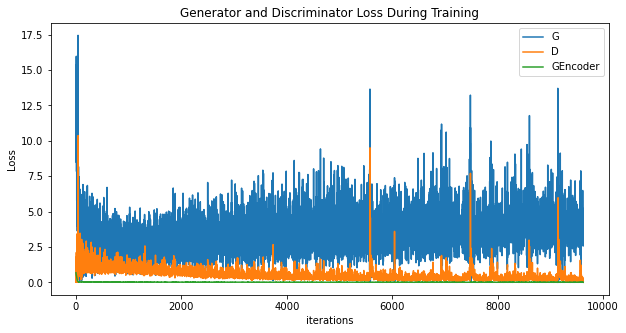

In [321]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(GenEncoder_losses,label="GEncoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

KeyboardInterrupt: 

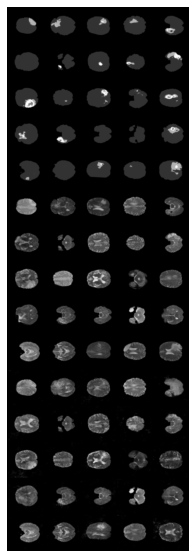

In [335]:
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [361]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)
fixed_T2_image = torch.stack([dataset_T2_test[i][0] for i in selected_index]).to(device)

In [362]:
selected_index

array([759, 630, 547,   5, 588, 316, 302, 517, 512, 190,  99, 104, 525,
       225, 115, 123, 443, 760, 345, 598, 649, 202, 353,  72, 273])

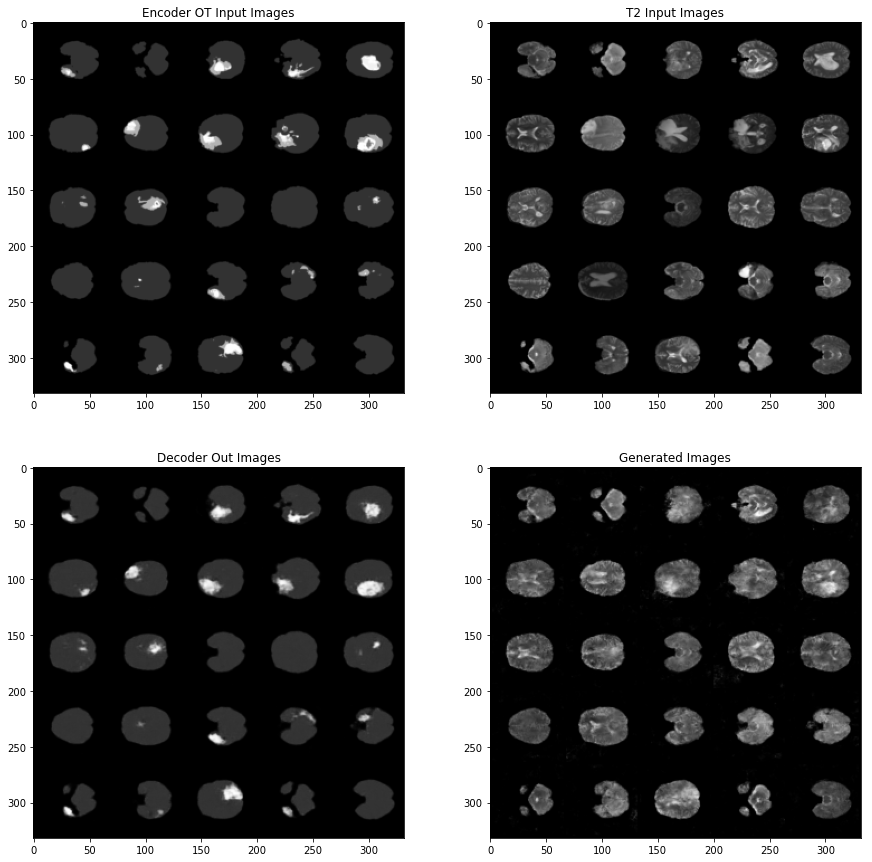

In [363]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)
    conv_1 = netDecoder.activation['conv_relu_1']
    conv_2 = netDecoder.activation['conv_relu_2']
    conv_3 = netDecoder.activation['conv_relu_3']
    conv_4 = netDecoder.activation['conv_relu_4']
 
    fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
    fake = netG(fixed_stacked_input,conv_1,conv_2,conv_3,conv_4).detach()
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(2, 2, 1)
plt.title("Encoder Input OT Images")
img = np.transpose(vutils.make_grid(fixed_OT_image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 2)
plt.title("Groundtruth T2 Images")
img = np.transpose(vutils.make_grid(fixed_T2_image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(2, 2, 3)
plt.title("Decoder Out OT Images")
img = np.transpose(vutils.make_grid(output, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 4)
plt.title("Generated Images")
img = np.transpose(vutils.make_grid(fake, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

## Results of using the representation of size 500

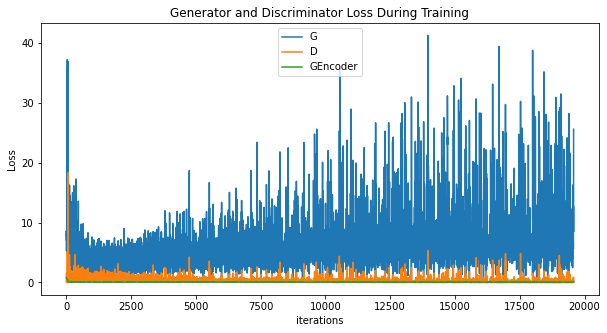

In [215]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(GenEncoder_losses,label="GEncoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [226]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)
fixed_T2_image = torch.stack([dataset_T2[i][0] for i in selected_index]).to(device)

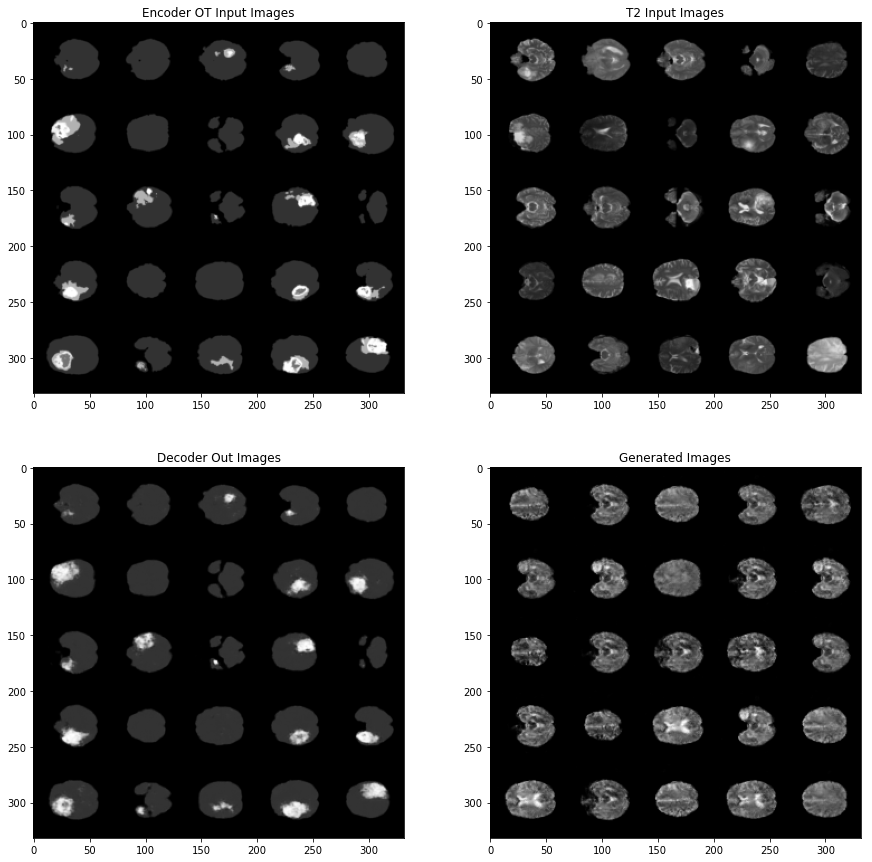

In [227]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)
 
    fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
    fake = netG(fixed_stacked_input).detach()
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(2, 2, 1)
plt.title("Encoder OT Input Images")
img = np.transpose(vutils.make_grid(fixed_OT_image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 2)
plt.title("T2 Input Images")
img = np.transpose(vutils.make_grid(fixed_T2_image, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

fig.add_subplot(2, 2, 3)
plt.title("Decoder Out Images")
img = np.transpose(vutils.make_grid(output, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 4)
plt.title("Generated Images")
img = np.transpose(vutils.make_grid(fake, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()

## Results of using the representation of size 100

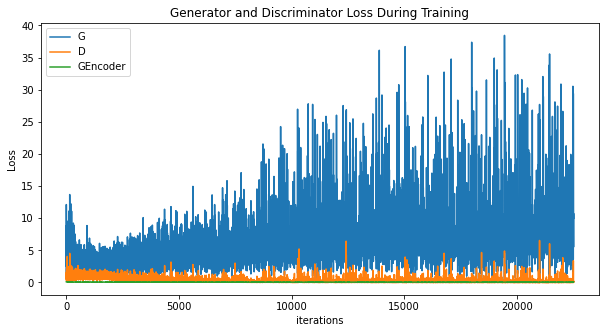

In [195]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.plot(GenEncoder_losses,label="GEncoder")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [199]:

selected_index = np.random.randint(len(dataset_OT_Back_test), size=fixed_noise_size)
fixed_OT_image = torch.stack([dataset_OT_Back_test[i][0] for i in selected_index]).to(device)

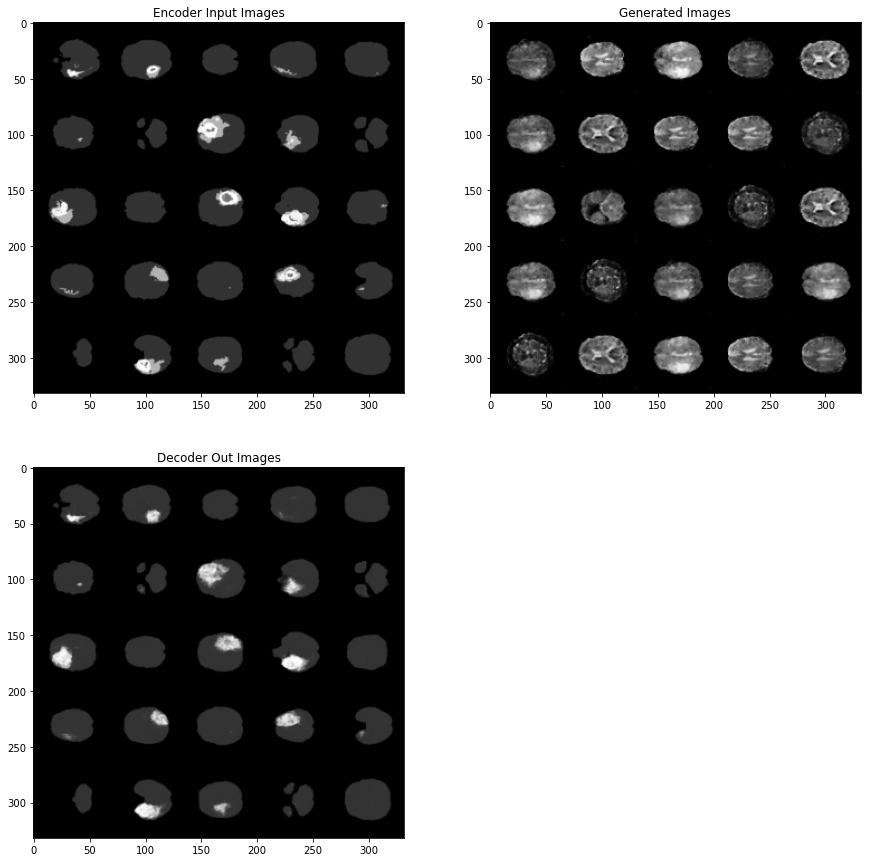

In [206]:
with torch.no_grad():
    real_cpu = fixed_OT_image
    #print("real_cpu.shape", real_cpu.shape)
    b_size = real_cpu.size(0)

    # Since we just updated D, perform another forward pass of all-fake batch through D 
    representation = netEncoder(real_cpu).view(b_size,-1,1,1) 
    output = netDecoder(representation).view(real_cpu.shape)
 
    fixed_stacked_input = torch.cat((fixed_noise[:b_size], representaion), dim=1)
    fake = netG(fixed_stacked_input).detach()
    

# Plot some training images 
fig=plt.figure(figsize=(15,15))
plt.axis("off")

fig.add_subplot(2, 2, 1)
plt.title("Encoder Input Images")
img = np.transpose(vutils.make_grid(real_cpu, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 3)
plt.title("Decoder Out Images")
img = np.transpose(vutils.make_grid(output, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)
 
fig.add_subplot(2, 2, 2)
plt.title("Generated Images")
img = np.transpose(vutils.make_grid(fake, padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(img)

plt.show()